In [1]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.dataset import *
from fastai.learner import *
from fastai.metrics import *
from fastai.core import *
from fastai.model import *
from fastai.lm_rnn import *
from collections import *
from fastai.conv_learner import *

In [2]:
normalize = torchvision.transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

In [3]:
preprocess = torchvision.transforms.Compose([
   torchvision.transforms.Resize(256),
   torchvision.transforms.CenterCrop(240),
   torchvision.transforms.ToTensor(),
   normalize
])

In [302]:
class PasswordDataset(Dataset):
    def __init__(self, files, ys):
        self.files = files
        self.ys = ys
        
    def __getitem__(self, idx):
        out = preprocess(PIL.Image.open(self.files[idx])).float().cuda()[:3], self.ys[idx].long().cuda()
        return out
    
    def __len__(self): return len(self.ys)
    
    @classmethod
    def from_files(cls, img_path, y_path, cv_idxs):
        files = np.array(sorted(glob(img_path), key=lambda x: int(re.findall('\d+', x)[0])))

        ys = None
        
        with open(y_path) as f:
            raw = f.read().split("\n")
            ys = np.array([int(x) for x in raw if x != ''])
        
        mask = np.zeros(len(files), dtype='bool')
        mask[cv_idxs] = True
        val_where = list(mask)
        trn_where = list(~mask)

        #trn_where = ~mask
        return cls(files[trn_where], torch.Tensor(ys[trn_where])), cls(files[val_where], torch.tensor(ys[val_where]))


In [303]:
image_paths = "/home/robert/Documents/typingviewer/data/*.png"

In [304]:
y_path = "/home/robert/Documents/typingviewer/data/y.csv"

In [305]:
dataset_size = len(glob(image_paths))

In [306]:
cv_idxs = get_cv_idxs(dataset_size, val_pct=0.1)

In [307]:
cv_idxs

array([5])

In [308]:
trn_ds, val_ds = PasswordDataset.from_files(image_paths, y_path, cv_idxs)

In [309]:
len(trn_ds)

10

In [310]:
len(val_ds)

1

In [311]:
trn_ds[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [312]:
bs = 2

In [313]:
trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=bs)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=bs)

In [314]:
class ConvNet(nn.Module):
    def __init__(self, out_dim=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        self.fc = nn.Linear(26*26*32, out_dim)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #print(out.size())
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [315]:
myConv = SingleModel(ConvNet().cuda())

In [316]:
md = ModelData('model', trn_dl, val_dl)

In [317]:
def faux_loss(preds):
    print(preds)

In [318]:
myConv = SingleModel(ConvnetBuilder(resnet18, 200, False, False).model)

In [319]:
myConv.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [320]:
#myConv.model[:-1]

In [321]:
learner = Learner(md, myConv, opt_fn=optim.Adam, crit=F.nll_loss)

In [322]:
learner.fit(1*1e-3, 1)

epoch      trn_loss   val_loss                          
    0      5.905624   12.676682 



[12.676681518554688]

In [323]:
class PasswordStatefulLSTM(nn.Module):
    def __init__(self, bs):
        super().__init__()
        
        self.cnn_final_width = 100
        self.number_rnn_layers = 1
        self.rnn_hidden_count = 100
        self.output_size = 10
        
        self.convToLSTM = nn.Linear(115200, self.cnn_final_width)
        
        self.flatten = Flatten()
        
        self.rnn = nn.LSTM(self.cnn_final_width, self.rnn_hidden_count, self.number_rnn_layers, dropout=0.5)
        self.l_out = nn.Linear(self.rnn_hidden_count, self.output_size)
        self.init_hidden(bs)
        #self.conv = ConvNet(out_dim=self.cnn_final_width)
        self.conv = ConvnetBuilder(resnet18, 200, False, False).model[:6]
        
    def forward(self, cs):
        #rnn_input = self.conv(cs).unsqueeze(1) #seq_len, batch, input_size
        rnn_input = self.convToLSTM(self.flatten(self.conv(cs)))
        rnn_input = rnn_input.unsqueeze(1)
        #print(rnn_input.shape)
        #bs = cs[0].size(0)
        #if self.h[0].size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(rnn_input, self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.output_size)
    
    def init_hidden(self, bs):
        #self.h = (V(torch.zeros(self.number_rnn_layers, bs, self.rnn_hidden_count)),
        #          V(torch.zeros(self.number_rnn_layers, bs, self.rnn_hidden_count)))
        self.h = (V(torch.zeros(1, 1, self.rnn_hidden_count)),
                  V(torch.zeros(1, 1, self.rnn_hidden_count)))

In [324]:
myLSTM = SingleModel(PasswordStatefulLSTM(bs).cuda())

/home/robert/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [325]:
learner = Learner(md, myLSTM, opt_fn=optim.Adam, crit=F.nll_loss)

In [327]:
learner.lr_find()

epoch      trn_loss   val_loss                          
    0      2.341938   20.116661 


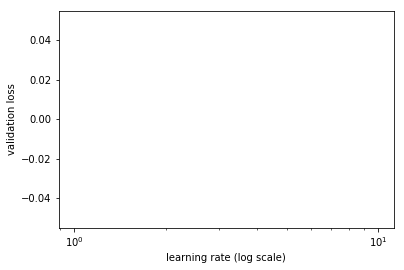

In [328]:
learner.sched.plot()

In [326]:
learner.fit(1*1e-3, 100)

epoch      trn_loss   val_loss                          
    0      2.359484   2.540649  
    1      2.330139   2.388866                          
    2      2.312612   2.579071                          
    3      2.303011   2.77332                           
    4      2.293665   3.045975                          
    5      2.288446   3.196745                          
    6      2.290898   3.301336                          
    7      2.283633   3.416417                          
    8      2.276063   3.507521                          
    9      2.268774   3.596356                          
    10     2.261806   3.681933                          
    11     2.255194   3.763864                          
 80%|████████  | 4/5 [00:01<00:00,  2.82it/s, loss=2.25]

KeyboardInterrupt: 